In [0]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2

# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [0]:
import numpy as np
import torch
the_seed = 42
def set_seed(seed):
    # Note, deterministic can impede performance
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
# Upload data
from google.colab import files
files.upload()

{}

In [0]:
#!tar xzf track_shower_images.tar.gz
#!tar xzf images.tar.gz
#!tar xzf images_reduced.tar.gz
#!tar xzf images_retagged.tar.gz
#!tar xzf images_u_hits.tar.gz
#!tar xzf images_u_truth.tar.gz
#!tar xzf images_v_hits.tar.gz
#!tar xzf images_v_truth.tar.gz
#!tar xzf images_w_hits.tar.gz
#!tar xzf images_w_truth.tar.gz
#!tar xzf quick_w.tar.gz
#!tar xzf multi_quick_w.tar.gz
#!tar xzf multi_w.tar.gz
!tar xzf charge_w.tar.gz
#!tar xzf charge_quick_w.tar.gz

# data.py

In [0]:
# data.py

import numpy as np
import torch
import os
import PIL
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

def open_image(path):
    img = PIL.Image.open(path)
    if img.mode  != 'L':
        img = img.convert('L')
    return img

class SegmentationDataset(Dataset):
    """Dataset suitable for segmentation tasks."""

    def __init__(self, image_dir, mask_dir, filenames, transform=None):
        """
        Args:
            root_dir (string): Directory with all images and masks.
            image_dir (string): The relative directory containing the images.
            mask_dir (string): The relative directory containing the masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = filenames
        self.mean = 0.
        self.std = 255.
        self.normalise = False
    
    def set_image_stats(self, mean, std):
        self.mean = mean
        self.std = std
    
    def set_normalisation(self, norm=True):
        self.normalise = norm

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.filenames[idx])
        image = np.asarray(open_image(img_name)).astype(np.float32)
        if self.normalise:
            image -= self.mean
            image /= self.std

        mask_name = os.path.join(self.mask_dir, self.filenames[idx])
        # If using categorical cross entropy, need an un-normalised long
        mask = np.asarray(open_image(mask_name)).astype(np.int_)
        sample = (image, mask)

        if self.transform:
            sample = self.transform(sample)

        return sample

class SegmentationBunch():
    """Associates batches of training, validation and testing datasets suitable
    for segmentation tasks."""
    def __init__(self, root_dir, image_dir, mask_dir, batch_size, valid_pct=0.1,
                 test_pct=0.0, transform=None):
        assert((valid_pct + test_pct) < 1.)
        image_dir = os.path.join(root_dir, image_dir)
        mask_dir = os.path.join(root_dir, mask_dir)
        transform = transform
        image_filenames = next(os.walk(image_dir))[2]
        random_list = np.random.choice(image_filenames, len(image_filenames),
                                       replace=False)
        valid_size = int(len(image_filenames) * valid_pct)
        test_size = int(len(image_filenames) * test_pct)
        train_size = len(image_filenames) - (valid_size + test_size)
        train_filenames = random_list[:train_size]
        valid_filenames = random_list[train_size:train_size + valid_size]
        self.valid_filenames = valid_filenames
        
        train_ds = SegmentationDataset(image_dir, mask_dir, train_filenames,
            transform)
        valid_ds = SegmentationDataset(image_dir, mask_dir, valid_filenames,
            transform)
        
        mu = 0.0
        for img, _ in train_ds:
            mu += torch.mean(img)
        mu /= len(train_ds)
        var_diff = 0.0
        for img, _ in train_ds:
            var_diff += ((img - mu)**2).sum()
        N = len(train_ds) * np.prod(np.array(img.shape))
        std = np.sqrt(var_diff / (N - 1))

        self.mean = mu.item()
        self.std = std.item()
        print(f"Training Mean: {self.mean} StdDev: {self.std}")
        train_ds.set_image_stats(*self.image_stats())
        train_ds.set_normalisation(True)
        # Update
        valid_ds.set_image_stats(*self.image_stats())
        valid_ds.set_normalisation(True)
        # End update
        self.train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
        self.valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)
        if test_size > 0:
            test_filenames = random_list[train_size + valid_size:]
            test_ds = SegmentationDataset(image_dir, mask_dir, test_filenames,
                transform)
            # Update
            test_ds.set_image_stats(*self.image_stats())
            test_ds.set_normalisation(True)
            # End update
            self.test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)
        else:
            self.test_dl = None
    
    def image_stats(self):
        # This needs to be stored somewhere
        # return 0.6969700455665588, 13.313282012939453
        return 0.558497428894043, 11.920382499694824

def count_classes(dl, num_classes):
    count = np.zeros(num_classes)
    for batch in dl:
        _, truth = batch
        unique, counts = torch.unique(truth, return_counts=True)
        unique = [ u.item() for u in unique ]
        counts = [ c.item() for c in counts ]
        this_dict = dict(zip(unique, counts))
        for key in this_dict:
                count[key] += this_dict[key]
    return count

# img_util.py

In [0]:
# img_utils.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def imagify(inputs, predictions, masks, void_code, n=3, randomize=True):
    """Process input, prediction and mask data ready for display
    Args:
        inputs (np.ndarray): Input tensor from a batch.
        predictions (np.ndarray): Predictions tensor from a batch.
        masks (np.ndarray): Mask tensor from a batch.
        void_code (int): The null mask code (typically zero).
        n (int): The number of images to extract from the batch.
        randomize (boolean): If True choose a random set of images from the
            batch, otherwise pick the first n.
    Returns:
        A zip of the three processed images ready for display.
    """
    # Select the images to process
    if randomize:
        choices = np.random.choice(np.array(range(inputs.shape[0])), size=n)
    else:
        choices = np.array(range(n))
    # Subset the inputs and masks
    input_imgs = inputs[choices,0,...]
    mask_imgs = masks[choices,...]

    # Create a void code mask, determine the class of each predicted pixel and
    # then apply the mask to remove non-hit regions
    msks = mask_imgs == void_code
    pred_imgs = np.argmax(predictions[choices,...], axis=1)
    pred_imgs = np.ma.array(pred_imgs, mask = msks).filled(0)
    if n > 1:
        return zip(pred_imgs, mask_imgs)
    else:
        return pred_imgs, mask_imgs
    #return zip(input_imgs, pred_imgs, mask_imgs)

def show_batch(epoch, batch, inputs, predictions, masks, void_code, is_training, n=3, randomize=True):
    """Display the images for a given epoch and batch. Each row is a triplet of
        input, prediction and mask.

    Args:
        epoch (int): The current training epoch.
        batch (int): The current training batch.
        inputs (np.ndarray): Input tensor from a batch.
        predictions (np.ndarray): Predictions tensor from a batch.
        masks (np.ndarray): Mask tensor from a batch.
        void_code (int): The null mask code (typically zero).
        n (int): The number of images to extract from the batch.
        randomize (boolean): If True choose a random set of images from the
            batch, otherwise pick the first n.
    """
    ax = None
    rows, cols = 1, 2
    size = 9

    cmap = ListedColormap(['black', 'red', 'blue'])
    norm = BoundaryNorm([0., 0.5, 1.5, 2.], cmap.N)

    xtr = dict(cmap=cmap, norm=norm, alpha=1.0)

    images = imagify(inputs, predictions, masks, void_code, n, randomize)

    for i, imgs in enumerate(images):
        # Produce output with 10% probability
        #if torch.rand(1).item() > 0.1: continue
        fig, axs = plt.subplots(1, cols, figsize=(cols * size, size))
        for img, ax in zip(imgs, axs):
            ax.imshow(img, **xtr)
            ax.axis('off')
        plt.tight_layout()
        if is_training: save_figure(plt, "training_{}_{}_{}".format(epoch, batch, i))
        else: save_figure(plt, "validation_{}_{}_{}".format(epoch, batch, i))
        plt.close(fig)

def save_figure(fig, name):
    """Output a matplotlib figure PNG, PDF and EPS formats.

    Args:
        fig (Figure): The matplotlib figure to save.
        name (str): The output filename excluding extension.
    """
    fig.savefig(name + ".png")
    fig.savefig(name + ".pdf")
    fig.savefig(name + ".eps")

def get_supported_formats():
    """Output a matplotlib figure PNG, PDF and EPS formats.

    Args:

    Returns:
        A dictionary containing strings of file format descriptions keyed by
            extension.
    """
    return plt.gcf().canvas.get_supported_filetypes()


# model_util.py

In [0]:
import numpy as np
from torch.optim.lr_scheduler import LambdaLR
from torch.autograd import Variable

def get_exponential_factor(start, stop, n, epoch):
    ratio = stop / start
    factor = ratio ** (1. / (n - 1))
    return factor ** epoch

def get_linear_factor(start, stop, n, epoch):
    target = start + (epoch / (n - 1.)) * (stop - start)
    return target / start

class LRFinder():
    def __init__(self, model, bunch, loss_fn, optim, num_iter, void_code,
                 low_lr=1e-7, high_lr=2, is_exponential=True):
        self.num_iter = num_iter
        if is_exponential:
            self.lambda_func = lambda batch : get_exponential_factor(low_lr, high_lr, self.num_iter, batch)
        else:
            self.lambda_func = lambda batch : get_linear_factor(low_lr, high_lr, self.num_iter, batch)
        self.scheduler = LambdaLR(optim, lr_lambda=self.lambda_func)
        self.learner = UNetLearner(model, bunch, loss_fn, optim, self.scheduler, void_code)
    
    def find(self):
        num_epochs = int(np.floor(self.num_iter/len(self.learner.bunch.train_dl)))
        for epoch in list(range(num_epochs)):
            # This is ugly, finder needs to know too much about learner
            train_dl = self.learner.bunch.train_dl
            for i, batch in enumerate(train_dl):
                self.learner.is_training = True
                self.learner._batch(epoch, i, batch)
                self.learner.evaluate(0)
    
    def get_lrs(self):
        return torch.Tensor(self.learner.history["lr"]).cpu()

    def get_losses(self):
        num_batches = len(self.learner.bunch.valid_dl)
        x = torch.Tensor(self.learner.history["val_loss"])
        x = x.reshape(x.size(0) // num_batches, num_batches).mean(axis = 1)
        return x.cpu()

    def get_accuracies(self):
        num_batches = len(self.learner.bunch.valid_dl)
        x = torch.Tensor(self.learner.history["val_acc"])
        x = x.reshape(x.size(0) // num_batches, num_batches).mean(axis = 1)
        return x.cpu()

# transforms.py

In [0]:
import torch
import numpy as np
from skimage import transform

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, is_categorical=False):
        self.is_categorical = is_categorical

    def __call__(self, sample):
        image, mask = sample

        image = torch.from_numpy(np.expand_dims(image, axis=0))
        if not self.is_categorical:
            mask = torch.from_numpy(np.expand_dims(mask, axis=0))
        else:
            mask = torch.from_numpy(mask)

        return (image, mask)

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample

        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        mask = transform.resize(mask, (new_h, new_w))

        return (img, mask)

# unet.py

In [0]:
import torch.nn as nn
import torch

def maxpool():
    return nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

def dropout(prob):
    return nn.Dropout(prob)

def reinit_layer(seq_block, leak = 0.0, use_kaiming_normal=True):
    for layer in seq_block:
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
            print("Reinitialising", layer)
            if use_kaiming_normal:
                nn.init.kaiming_normal_(layer.weight, a = leak)
            else:
                nn.init.kaiming_uniform_(layer.weight, a = leak)
                layer.bias.data.zero_()

class InitBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super(InitBlock, self).__init__()
        self.conv = nn.Conv2d(c_in, c_out, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(c_out)
        self.pool = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.block = nn.Sequential(self.conv, self.relu, self.bn)#, self.pool)
        reinit_layer(self.block, leak = 0.0)

    def forward(self, x):
        return self.block(x)

class ResBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super(ResBlock, self).__init__()
        if c_out != c_in:
            # In principle this should be stride 2 and no maxpool after
            self.conv1 = nn.Conv2d(c_in, c_out, kernel_size = 3, stride = 1, padding = 1, bias = False)
        else:
            self.conv1 = nn.Conv2d(c_in, c_out, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size = 3, padding = 1, stride = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(c_out)
        self.block = nn.Sequential(self.conv1, self.bn1, self.relu, self.conv2, self.bn2)
        if c_out != c_in:
            # May need to become stride 2 if stride above is included again
            ds_conv = nn.Conv2d(c_in, c_out, kernel_size = 1, stride = 1, bias = False)
            ds_bn = nn.BatchNorm2d(c_out)
            self.downsample = nn.Sequential(ds_conv, ds_bn)
        else:
            self.downsample = None
        reinit_layer(self.block, leak = 0.0)

    def forward(self, x):
        identity = x
        out = self.block(x)
        if self.downsample: identity = self.downsample(x)
        out += identity
        out = self.relu(out)

        return out

class ConvBlock(nn.Module):
    # Sigmoid activation suitable for binary cross-entropy
    def __init__(self, c_in, c_out, k_size = 3, k_pad = 1):
        # 3, 1 v 5, 2
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size = k_size, padding = k_pad, stride = 1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, kernel_size = k_size, padding = k_pad, stride = 1),
            nn.BatchNorm2d(c_out))
        reinit_layer(self.block)

    def forward(self, x):
        return self.block(x)

class ConvBlockOld(nn.Module):
    # Sigmoid activation suitable for binary cross-entropy
    def __init__(self, c_in, c_out):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out),
            nn.Conv2d(c_out, c_out, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out))
        reinit_layer(self.block)

    def forward(self, x):
        return self.block(x)

class TransposeConvBlock(nn.Module):
    # Sigmoid activation suitable for binary cross-entropy
    def __init__(self, c_in, c_out, k_size = 3, k_pad = 1):
        # 3, 1 v 5,2
        super(TransposeConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(c_in, c_out, kernel_size = k_size, padding = k_pad, output_padding = 1, stride = 2),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True))
        reinit_layer(self.block)

    def forward(self, x):
        return self.block(x)

class TransposeConvBlockOld(nn.Module):
    # Sigmoid activation suitable for binary cross-entropy
    def __init__(self, c_in, c_out):
        super(TransposeConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(c_in, c_out, kernel_size = 3, padding = 1, output_padding = 1, stride = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out))
        reinit_layer(self.block)

    def forward(self, x):
        return self.block(x)

class Sigmoid(nn.Module):
    # Sigmoid activation suitable for binary cross-entropy
    def __init__(self):
        super(Sigmoid, self).__init__()
    
    def forward(self, x):
        return torch.sigmoid(x)

class SigmoidRange(nn.Module):
    # Sigmoid activation suitable for categorical cross-entropy
    def __init__(self, low, high):
        super(SigmoidRange, self).__init__()
        self.low = low
        self.high = high
    
    def forward(self, x):
        return torch.sigmoid(x) * (self.high - self.low) + self.low

class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        for i, module in enumerate(args):
            self.add_module(str(i), module)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

class UNet(nn.Module):
    def __init__(self, in_dim, n_classes, depth = 4, n_filters = 16, drop_prob = 0.1, y_range = None):
        super(UNet, self).__init__()
        # Contracting Path
        ds_convs = []
        for i in range(depth):
            if i == 0: ds_convs.append(ConvBlock(in_dim, n_filters * 2**i))
            else: ds_convs.append(ConvBlock(n_filters * 2**(i - 1), n_filters * 2**i))
        self.ds_convs = ListModule(*ds_convs)

        ds_maxpools = []
        for i in range(depth):
            ds_maxpools.append(maxpool())
        self.ds_maxpools = ListModule(*ds_maxpools)
        
        ds_dropouts = []
        for i in range(depth):
            ds_dropouts.append(dropout(drop_prob))
        #self.ds_dropouts = ListModule(*ds_dropouts)

        self.bridge = ConvBlock(n_filters * 2**(depth - 1), n_filters * 2**depth)
        
        # Expansive Path
        us_tconvs = []
        for i in range(depth, 0, -1):
            us_tconvs.append(TransposeConvBlock(n_filters * 2**i, n_filters * 2**(i - 1)))
        self.us_tconvs = ListModule(*us_tconvs)

        us_convs = []
        for i in range(depth, 0, -1):
            us_convs.append(ConvBlock(n_filters * 2**i, n_filters * 2**(i - 1)))
        self.us_convs = ListModule(*us_convs)

        us_dropouts = []
        for i in range(depth):
            us_dropouts.append(dropout(drop_prob))
        #self.us_dropouts = ListModule(*us_dropouts)

        # Assume 3 classes to figure out
        if y_range is not None:
            self.output = nn.Sequential(
                nn.Conv2d(n_filters * 1, n_classes, 1),
                #Sigmoid(),
                SigmoidRange(*y_range)
            )
        else:
            self.output = nn.Sequential(
                nn.Conv2d(n_filters * 1, n_classes, 1)
            )

    def forward(self, x):
        res = x
        conv_stack = []

        # Downsample
        for i in range(len(self.ds_convs)):
            res = self.ds_convs[i](res); conv_stack.append(res)
            res = self.ds_maxpools[i](res)
            #res = self.ds_dropouts[i](res)
        
        # Bridge
        res = self.bridge(res)
        
        # Upsample
        for i in range(len(self.us_convs)):
            res = self.us_tconvs[i](res)
            res = torch.cat([res, conv_stack.pop()], dim=1)
            #res = self.us_dropouts[i](res)
            res = self.us_convs[i](res)

        output = self.output(res)
        #print(output.size())
        return output

# UNetLearner

In [0]:
SHOWER = 1
MIP = 2
HIP = 3
#MICHEL = 4

NUM_CLASSES = 4 #5
is_last_epoch = False

confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))

def print_confusion_matrix():
    def print_matrix(mat):
        for r in range(NUM_CLASSES):
            for c in range(NUM_CLASSES):
                print("{:7.3f}".format(mat[r, c]), end='')
            print()
        print()
    global confusion_matrix
    sum0 = np.sum(confusion_matrix, axis=0); sum0[sum0 == 0] = 1.
    sum1 = np.sum(confusion_matrix, axis=1, keepdims=True); sum1[sum1 == 0] = 1.
    p_given_truth = confusion_matrix / sum0
    p_given_pred = confusion_matrix / sum1
    print("P | truth:")
    print_matrix(p_given_truth)
    print("P | pred:")
    print_matrix(p_given_pred)

def switch_batch_norm(model, track_running_stats):
    for group in model.children():
        if type(group) == nn.Sequential:
            for child in group:
                if type(child) == nn.BatchNorm2d:
                    child.track_running_stats = track_running_stats

def summarize_epoch(history, n_train_batches, n_valid_batches):
    epoch = len(history["train_loss"]) // n_train_batches
    train_loss = torch.Tensor(history["train_loss"][-n_train_batches:]).mean()
    train_acc = torch.Tensor(history["train_acc"][-n_train_batches:]).mean()
    valid_loss = torch.Tensor(history["val_loss"][-n_valid_batches:]).mean()
    valid_acc = torch.Tensor(history["val_acc"][-n_valid_batches:]).mean()
    valid_acc_cls = {}
    for cls in range(1,NUM_CLASSES):
        valid_acc_cls[cls] = torch.Tensor(history[f"train_acc_{cls}"][-n_valid_batches:]).mean()
        valid_acc_cls[cls] = torch.Tensor(history[f"val_acc_{cls}"][-n_valid_batches:]).mean()

    print("Epoch {} : Training Loss {:.3f} Acc {:.3f} Validation Loss {:.3f} " \
          "Acc {:.3f} ".format(epoch, train_loss, train_acc, valid_loss, valid_acc))
    for cls in range(1, NUM_CLASSES):
        print(f"   Acc {cls} {valid_acc_cls[cls]:.3f}")

def save_network(model, input, filename):
    eval_model = model.eval()
    torch.save(eval_model.state_dict(), f"{filename}.pkl")
    # Load later with:
    # model.load_state_dict(torch.load(PATH))
    # model.eval()

    sm = torch.jit.trace(eval_model, input, check_trace=False)
    sm.save(f"{filename}_traced.pt")

    #sm = torch.jit.script(model)
    #sm.save(f"{filename}_script.pt")

class UNetLearner:
    def __init__(self, model, bunch, loss_fn, optim, scheduler, void_code=0):
        self.model = model
        self.bunch = bunch
        self.loss_fn = loss_fn
        self.optim = optim
        self.scheduler = scheduler
        self.void_code = void_code
        self.is_training = True
        self.verbose = 0
        self.history = {"lr" : [], "train_loss" : [], "train_acc" : [],
                        "val_loss" : [], "val_acc" : [],
                        "train_acc_1" : [], "val_acc_1" : [],
                        "train_acc_2" : [], "val_acc_2" : [],
                        "train_acc_3" : [], "val_acc_3" : [],
                        "train_acc_4" : [], "val_acc_4" : [],
                        "train_acc_5" : [], "val_acc_5" : [],
                        "train_acc_6" : [], "val_acc_6" : [],
                        "train_acc_7" : [], "val_acc_7" : []}

    def train(self, n_epochs):
        global is_last_epoch
        self.model = self.model.cuda()
        for e in range(n_epochs):
            if e == (n_epochs - 1): is_last_epoch = True
            # Train
            self.is_training = True
            self.model = self.model.train()
            self._epoch(e)
            # Save the network
            for batch in self.bunch.valid_dl:
                example, _ = batch
                example = Variable(example).cuda()
                save_network(model, example, f"unet_{e}")

            # Validate
            self.model = self.model.eval()
            switch_batch_norm(self.model, False)
            with torch.no_grad():
                self.evaluate(e)
            switch_batch_norm(self.model, True)
            summarize_epoch(self.history, len(self.bunch.train_dl),
                            len(bunch.valid_dl))
    
    def evaluate(self, e):
        self.is_training = False
        self._epoch(e)

    def _batch(self, e, b, batch):
        images, truth = batch
        x = Variable(images).cuda()
        y = Variable(truth).cuda()
        pred = self.model.forward(x)
        loss = self.loss_fn(pred, y)

        key = "train" if self.is_training else "val"
        if self.is_training:
            self.history["lr"].append(self.scheduler.get_lr()[0])
        self.history[f"{key}_loss"].append(loss.item())
        self.history[f"{key}_acc"].append(self.accuracy(pred, y))
        for cls in range(1, NUM_CLASSES):
            self.history[f"{key}_acc_{cls}"].append(self.accuracy(pred, y, cls))

        if not self.is_training and self.verbose > 0:
            if self.verbose > 1: #and b == (len(self.bunch.valid_dl) - 1):
                net_input = x.cpu().detach().numpy()
                net_pred = pred.cpu().detach().numpy()
                net_mask = y.cpu().detach().numpy()
                show_batch(e, b, net_input, net_pred, net_mask, self.void_code,
                            self.is_training, n = images.shape[0], randomize=False)
                label = "Training" if self.is_training else "Validation"
                print("Batch {}: {} Loss: {:.3f} Acc: {:.3f} S Acc: {:.3f} T Acc: {:.3f}".format(
                    b + 1, label, loss.item(), self.history[f"{key}_acc"][-1],
                    self.history[f"{key}_acc_shower"][-1], self.history[f"{key}_acc_track"][-1]))                

                print("Batch {} : {} Loss {:.3f} Acc {:.3f}".format(b + 1, label,
                    loss.item(), self.history[f"{key}_acc"][-1]))
                for cls in range(1, NUM_CLASSES):
                    if key == "val": print(f"   Acc {cls} {valid_acc_cls[cls]:.3f}")
                    else: print(f"   Acc {cls} {train_acc_cls[cls]:.3f}")

        if self.is_training:
            loss.backward()
            self.optim.step()
            self.scheduler.step()
            self.optim.zero_grad()

    def _epoch(self, epoch):
        global confusion_matrix
        global is_last_epoch
        confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
        dl = self.bunch.train_dl if self.is_training else self.bunch.valid_dl
        for i, batch in enumerate(dl):
            self._batch(epoch, i, batch)
        if is_last_epoch:
            print_confusion_matrix()        
    
    def set_verbose(self, verbose):
        self.verbose = verbose

    def accuracy(self, input, truth, type=None):
        global is_last_epoch
        target = truth.squeeze(1)
        if type is None:
            mask = target != self.void_code
        else:
            mask = target == type
        if is_last_epoch:
            all_inputs = input.argmax(dim=1)[mask]
            all_targets = target[mask]
            all_pairs = list(zip(all_inputs, all_targets))
            for pair in all_pairs:
                confusion_matrix[pair[0], pair[1]] += 1
        return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

# One-Cycle learner

In [0]:
class LRExponentialOneCycle(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optim, base_lr, max_lr, min_lr, total_batches, pct_start=0.2, last_epoch=-1):
        self.optim = optim
        self.total_steps = total_batches
        self.n_increasing_steps = int(total_batches * pct_start)
        self.n_decreasing_steps = total_batches - self.n_increasing_steps
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.min_lr = min_lr
        if last_epoch == -1:
            for idx, group in enumerate(self.optim.param_groups):
                group['lr'] = base_lr
                group['max_lr'] = max_lr
                group['min_lr'] = min_lr
        super(LRExponentialOneCycle, self).__init__(optim, last_epoch)
    
    def anneal(self, start, stop, n):
        ratio = stop / start
        factor = ratio ** (1. / (n - 1))
        if self.last_epoch < self.n_increasing_steps:
            epoch = self.last_epoch
        else:
            epoch = 1 + self.last_epoch - self.n_increasing_steps
        return start * factor ** epoch

    def get_lr(self):
        lrs = []
        step_num = self.last_epoch
        if step_num < self.n_increasing_steps:
            lr = self.anneal(self.base_lr, self.max_lr, self.n_increasing_steps)
        elif step_num < self.total_steps:
            lr = self.anneal(self.max_lr, self.min_lr, 1 + self.n_decreasing_steps)
        else:
            lr = self.min_lr
        lrs.append(lr)
        return lrs

# Check image

In [0]:
#from data import open_image
#img = open_image("Images/Truth/Image_DUNEFD_MC11_CaloHitListW_0_0.png")
img = open_image("Images/Truth/Image_DUNEFD_MC11_CaloHitListW_0_0_4.png")
img.size

# Setup

In [0]:
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.optim as opt
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# This line is important for GPU running, otherwise some weights end up on the CPU - not sure where - maybe Kaiming reinit?
torch.set_default_tensor_type(torch.cuda.FloatTensor)
set_seed(the_seed)
batch_size=96#48
bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=batch_size, valid_pct = 0.3,
    transform=transforms.Compose([ToTensor(True)]))
#bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=16, valid_pct = 0.2,
#    transform=transforms.Compose([ToTensor(True)]))
#train_stats = count_classes(bunch.train_dl, 3)
#valid_stats = count_classes(bunch.valid_dl, 3)
#print(f"Training - Batches: {len(bunch.train_dl)}  Track hits: {train_stats[2]}  Shower hits: {train_stats[1]}  Null hits: {train_stats[0]}")
#print(f"Validation - Batches: {len(bunch.valid_dl)}  Track hits: {valid_stats[2]}  Shower hits: {valid_stats[1]}  Null hits: {valid_stats[0]}")

Training Mean: 0.08113545924425125 StdDev: 1.9055533409118652


In [0]:
train_stats = count_classes(bunch.train_dl, NUM_CLASSES)

In [0]:
print(train_stats)

[7.27002646e+08 6.94676000e+05 1.89670700e+06 2.14867000e+05]


In [0]:
def get_class_weights(stats):
    weights = 1. / stats
    return [weight / sum(weights) for weight in weights]

weights = get_class_weights(train_stats)
weights

[0.00020771310006738474,
 0.21737899878195224,
 0.0796158675841084,
 0.702797420533872]

In [0]:
# Create the network, loss function and optimizer
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR
set_seed(the_seed)
num_epochs = 20
#pct_start = 2.5 / num_epochs
#pct_start = 1. / num_epochs
pct_start = 2. / num_epochs
n_classes = 4 #5
wd = 1e-5 #1e-4
#max_lr = 1e-3
max_lr = 2e-3 #1e-2
base_lr = 1e-5 #1e-4
min_lr = 1e-6 #1e-7
div_factor = max_lr / base_lr
final_factor = base_lr / min_lr
#model = UNet(1, n_classes = n_classes, depth = 4, n_filters = 16, y_range = (0, n_classes))
model = UNet(1, n_classes = n_classes, depth = 4, n_filters = 16, y_range = (0, n_classes))
loss_fn = nn.CrossEntropyLoss(torch.tensor(weights))
optim = opt.Adam(model.parameters(), lr=max_lr, weight_decay=wd)
#optim = opt.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=wd)
# Standard One-Cycle LR
#scheduler = OneCycleLR(optim, max_lr, anneal_strategy='linear', total_steps = num_epochs * len(bunch.train_dl), pct_start=0.30, div_factor=div_factor, final_div_factor=10)
# Exp One-Cycle LR
#scheduler = LRExponentialOneCycle(optim, base_lr, max_lr, min_lr, num_epochs * len(bunch.train_dl), pct_start=0.5)
# Exp decay LR
#scheduler = LambdaLR(optim, lr_lambda=lambda batch : get_exponential_factor(max_lr, min_lr, num_epochs * len(bunch.train_dl), batch))
# Constant LR
#scheduler = LambdaLR(optim, lr_lambda=lambda batch : 1.)
# Linear decay LR
#scheduler = LambdaLR(optim, lr_lambda=lambda batch : get_linear_factor(max_lr, min_lr, num_epochs * len(bunch.train_dl), batch))
# Linear One-Cycle LR
#scheduler = OneCycleLR(optim, max_lr, anneal_strategy='linear', total_steps = num_epochs * len(bunch.train_dl), pct_start=0.50, div_factor=div_factor, final_div_factor=final_factor)
# Cosine One-Cycle LR
scheduler = OneCycleLR(optim, max_lr, anneal_strategy='cos', total_steps = num_epochs * len(bunch.train_dl), pct_start=pct_start, div_factor=div_factor, final_div_factor=final_factor)
learner = UNetLearner(model, bunch, loss_fn, optim, scheduler)

Reinitialising Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
Reinitialising ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2

# Find learning rate

In [0]:
def explore_learning_rates(depth, weight_decays):
    lrs = []
    losses = []
    accuracies = []
    low_lr = 1e-6
    high_lr = 2.
    for wd in weight_decays:
        set_seed(the_seed)
        model = UNet(1, n_classes = n_classes, depth = depth, n_filters = 16, y_range = (0, n_classes))
        loss_fn = nn.CrossEntropyLoss(torch.tensor(weights))
        optim = opt.Adam(model.parameters(), lr=low_lr, weight_decay=wd)
        #optim = opt.SGD(model.parameters(), lr=low_lr, momentum=0.9, weight_decay=wd)
        #lr_finder = LRFinder(model, bunch, loss_fn, optim, 96, 0, low_lr=1e-6, high_lr=2)
        #lr_finder = LRFinder(model, bunch, loss_fn, optim, 2 * len(bunch.train_dl), 0, low_lr=low_lr, high_lr=high_lr)
        lr_finder = LRFinder(model, bunch, loss_fn, optim, 10 * len(bunch.train_dl), 0, low_lr=low_lr, high_lr=high_lr)
        lr_finder.find()
        lrs.append(lr_finder.get_lrs())
        losses.append(lr_finder.get_losses())
        accuracies.append(lr_finder.get_accuracies())
    return lrs, losses, accuracies

In [0]:
len(bunch.train_dl)

5

In [0]:
lrs, losses, accuracies = explore_learning_rates(4, [0., 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])

Reinitialising Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
Reinitialising ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Reinitialising Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
Reinitialising ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2

In [0]:
def plot_lr(lrs, losses, accuracies, name, labels=("lr", "loss", "acc")):
    fig, ax = plt.subplots()
    ax.set_title('Learning Rate Finder')
    ax.set_xlabel("lr")
    ax.set_xscale("log")
    ax.plot(lrs, losses, c='black', label="Loss")
    ax.plot(lrs, accuracies, c='red', label="Accuracy")
    plt.legend()
    save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

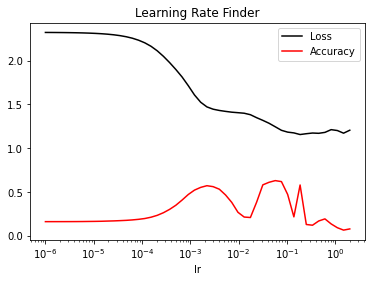

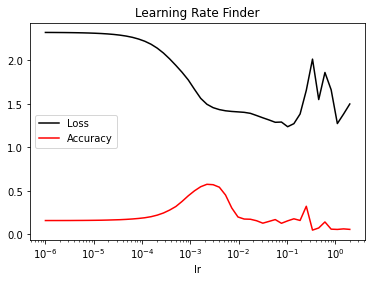

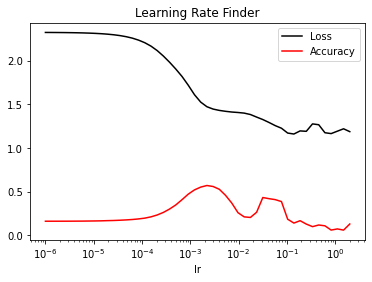

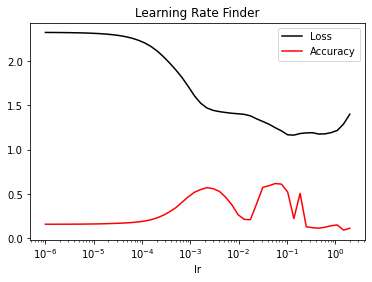

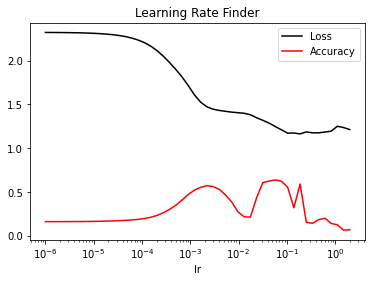

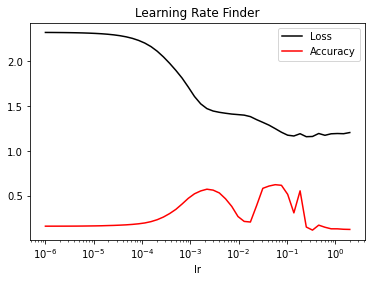

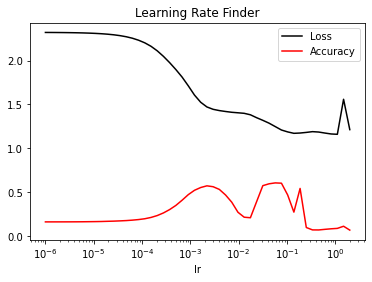

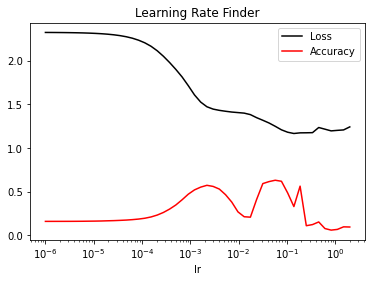

In [0]:
for i in range(len(lrs)):
    plot_lr(lrs[i], losses[i], accuracies[i], f"LearningRateFinder_{i}")

In [0]:
def plot_lr_variable(lrs, vars, label, name, wds):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title('')
    ax.set_xlabel("lr", fontsize=20)
    ax.set_xscale("log")
    ax.set_ylabel(label, fontsize=20)
    plt.tick_params(labelsize=20)
    for i in range(len(vars)):
        if i > 2:
            ax.plot(lrs, vars[i], label=f"wd = {wds[i]:.0E}")
        else:
            ax.plot(lrs, vars[i], label=f"wd = {wds[i]}")
    plt.legend(prop={'size': 20})
    save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


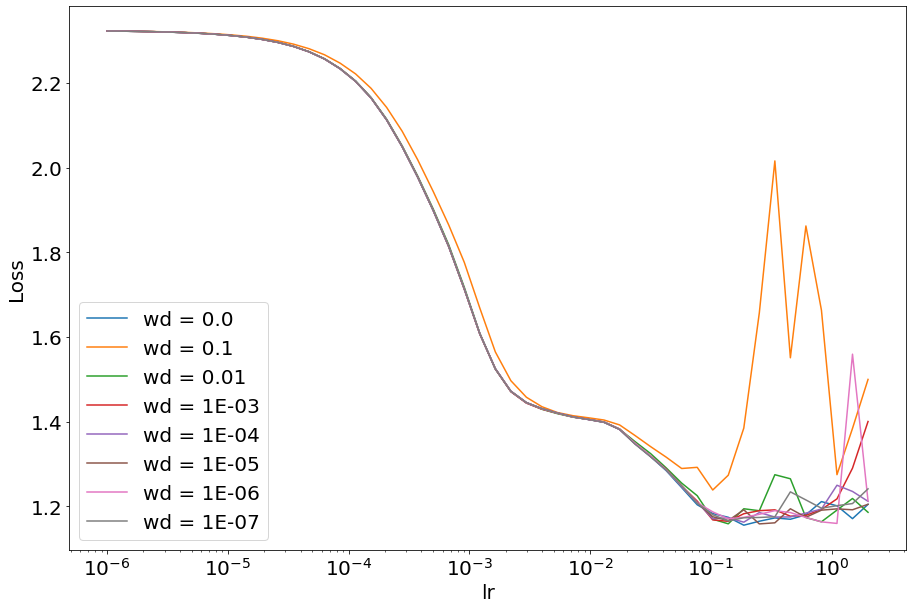

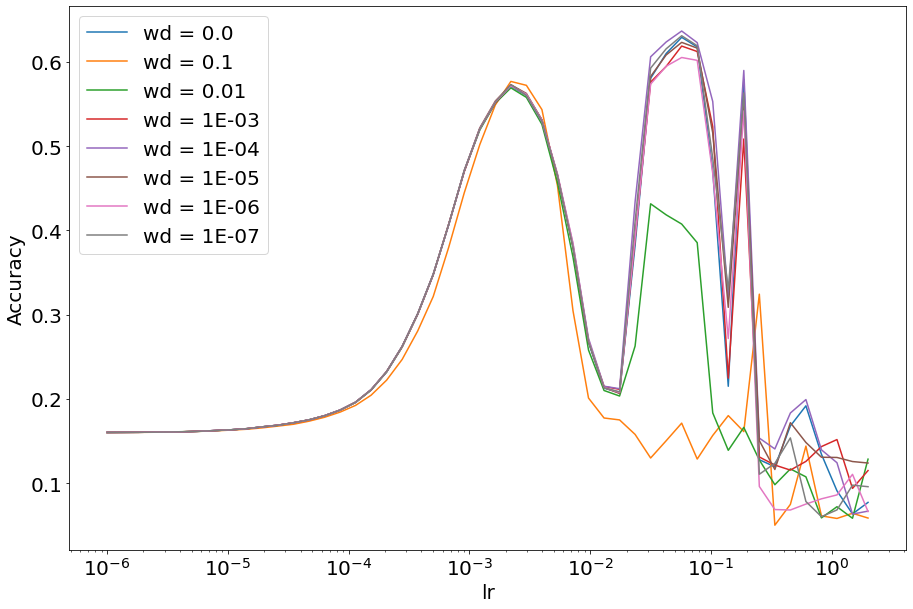

In [0]:
from operator import itemgetter
wds = [0., 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
sub_wds = itemgetter(0, 1, 2, 3, 4, 5, 6, 7)(wds)
sub_losses = itemgetter(0, 1, 2, 3, 4, 5, 6, 7)(losses)
sub_accuracies = itemgetter(0, 1, 2, 3, 4, 5, 6, 7)(accuracies)
plot_lr_variable(lrs[0], sub_losses, "Loss", "LRFinderLosses", sub_wds)
plot_lr_variable(lrs[0], sub_accuracies, "Accuracy", "LRFinderAccuracies", sub_wds)

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps

LearningRateFinder_0.png
LearningRateFinder_1.png
LearningRateFinder_2.png
LearningRateFinder_3.png
LearningRateFinder_4.png
LearningRateFinder_5.png
LearningRateFinder_6.png
LearningRateFinder_7.png
LRFinderAccuracies.png
LRFinderLosses.png
LearningRateFinder_0.pdf
LearningRateFinder_1.pdf
LearningRateFinder_2.pdf
LearningRateFinder_3.pdf
LearningRateFinder_4.pdf
LearningRateFinder_5.pdf
LearningRateFinder_6.pdf
LearningRateFinder_7.pdf
LRFinderAccuracies.pdf
LRFinderLosses.pdf
LearningRateFinder_0.eps
LearningRateFinder_1.eps
LearningRateFinder_2.eps
LearningRateFinder_3.eps
LearningRateFinder_4.eps
LearningRateFinder_5.eps
LearningRateFinder_6.eps
LearningRateFinder_7.eps
LRFinderAccuracies.eps
LRFinderLosses.eps


In [0]:
files.download("images.tar.gz")

# Setup hooks

In [0]:
# Register hooks for feature map visualisation
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for i in range(4):
    model.ds_convs[i].register_forward_hook(get_activation(f'DSConv{i+1}'))
model.bridge.register_forward_hook(get_activation('Bridge'))
for i in range(4):
    model.us_tconvs[i].register_forward_hook(get_activation(f'USTConv{i + 1}'))
for i in range(4):
    model.us_convs[i].register_forward_hook(get_activation(f'USConv{i + 1}'))

# Train network

In [0]:
set_seed(the_seed)
learner.set_verbose(0)

In [0]:
# Run
num_epochs = 20
learner.train(num_epochs)

Epoch 1 : Training Loss 1.318 Acc 0.469 Validation Loss 0.977 Acc 0.723 
   Acc 1 0.722
   Acc 2 0.754
   Acc 3 0.385
Epoch 2 : Training Loss 0.814 Acc 0.740 Validation Loss 0.636 Acc 0.796 
   Acc 1 0.941
   Acc 2 0.770
   Acc 3 0.565
Epoch 3 : Training Loss 0.583 Acc 0.766 Validation Loss 0.746 Acc 0.845 
   Acc 1 0.945
   Acc 2 0.869
   Acc 3 0.242
Epoch 4 : Training Loss 0.483 Acc 0.791 Validation Loss 0.565 Acc 0.510 
   Acc 1 0.811
   Acc 2 0.366
   Acc 3 0.942
Epoch 5 : Training Loss 0.428 Acc 0.815 Validation Loss 0.393 Acc 0.852 
   Acc 1 0.957
   Acc 2 0.831
   Acc 3 0.691
Epoch 6 : Training Loss 0.399 Acc 0.823 Validation Loss 0.384 Acc 0.804 
   Acc 1 0.871
   Acc 2 0.773
   Acc 3 0.864
Epoch 7 : Training Loss 0.378 Acc 0.827 Validation Loss 0.351 Acc 0.839 
   Acc 1 0.935
   Acc 2 0.809
   Acc 3 0.793
Epoch 8 : Training Loss 0.359 Acc 0.835 Validation Loss 0.371 Acc 0.771 
   Acc 1 0.968
   Acc 2 0.698
   Acc 3 0.833
Epoch 9 : Training Loss 0.338 Acc 0.840 Validation Loss 

In [0]:
!ls -l *.pkl *.pt

-rw-r--r-- 1 root root 8689260 Apr  7 08:34 unet_0.pkl
-rw-r--r-- 1 root root 8830537 Apr  7 08:35 unet_0_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 09:50 unet_10.pkl
-rw-r--r-- 1 root root 8831206 Apr  7 09:50 unet_10_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 09:57 unet_11.pkl
-rw-r--r-- 1 root root 8831206 Apr  7 09:57 unet_11_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 10:05 unet_12.pkl
-rw-r--r-- 1 root root 8831206 Apr  7 10:05 unet_12_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 10:12 unet_13.pkl
-rw-r--r-- 1 root root 8831206 Apr  7 10:12 unet_13_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 10:20 unet_14.pkl
-rw-r--r-- 1 root root 8831206 Apr  7 10:20 unet_14_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 10:27 unet_15.pkl
-rw-r--r-- 1 root root 8831206 Apr  7 10:27 unet_15_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 10:35 unet_16.pkl
-rw-r--r-- 1 root root 8831206 Apr  7 10:35 unet_16_traced.pt
-rw-r--r-- 1 root root 8689260 Apr  7 10:42 unet_17.pkl
-r

In [0]:
!tar czf models1_20.tar.gz unet_0.pkl unet_1.pkl unet_2.pkl
!tar czf models2_20.tar.gz unet_3.pkl unet_4.pkl unet_5.pkl
!tar czf models3_20.tar.gz unet_6.pkl unet_7.pkl unet_8.pkl unet_9.pkl
files.download("models1_20.tar.gz")
files.download("models2_20.tar.gz")
files.download("models3_20.tar.gz")
#!tar czf models_1epoch_traced.tar.gz unet_0.pkl unet_0_traced.pt
#files.download("models_1epoch_traced.tar.gz")

In [0]:
!tar czf model_multi_20.tar.gz unet_19.pkl
files.download("unet_19.pkl")

# Inference

In [0]:
!rm -rf Images
from google.colab import files
files.upload()

Saving images_v_hits.tar.gz to images_v_hits.tar.gz
Saving images_v_truth.tar.gz to images_v_truth.tar.gz
Saving images_w_hits.tar.gz to images_w_hits.tar.gz
Saving images_w_truth.tar.gz to images_w_truth.tar.gz


In [0]:
!rm -rf Images
!tar xzf images_w_hits.tar.gz
!tar xzf images_w_truth.tar.gz

In [0]:
model = UNet(1, n_classes = n_classes, depth = 4, n_filters = 16, y_range = (0, n_classes))
# Need optim and scheduler because we're testing entire batches 
model.load_state_dict(torch.load("unet_9.pkl"))
loss_fn = nn.CrossEntropyLoss(torch.tensor(weights))
learner = UNetLearner(model, bunch, loss_fn, None, None)

Reinitialising Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reinitialising ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
Reinitialising ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2

In [0]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
set_seed(the_seed)
batch_size=96#48
bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=batch_size, valid_pct = 0.3,
    transform=transforms.Compose([ToTensor(True)]))

set_seed(the_seed)
learner = UNetLearner(model, bunch, loss_fn, None, None)
learner.set_verbose(1)
learner.evaluate(10)

Batch 1: Validation Loss: 0.182 Acc: 0.934 S Acc: 0.972 T Acc: 0.916
Batch 2: Validation Loss: 0.184 Acc: 0.925 S Acc: 0.985 T Acc: 0.902
Batch 3: Validation Loss: 0.151 Acc: 0.956 S Acc: 0.962 T Acc: 0.954
Batch 4: Validation Loss: 0.158 Acc: 0.953 S Acc: 0.950 T Acc: 0.954
Batch 5: Validation Loss: 0.156 Acc: 0.941 S Acc: 0.931 T Acc: 0.945
Batch 6: Validation Loss: 0.180 Acc: 0.934 S Acc: 0.965 T Acc: 0.920
Batch 7: Validation Loss: 0.154 Acc: 0.953 S Acc: 0.970 T Acc: 0.951
Batch 8: Validation Loss: 0.162 Acc: 0.947 S Acc: 0.987 T Acc: 0.930
Batch 9: Validation Loss: 0.180 Acc: 0.938 S Acc: 0.952 T Acc: 0.932
Batch 10: Validation Loss: 0.150 Acc: 0.949 S Acc: 0.966 T Acc: 0.946
Batch 11: Validation Loss: 0.152 Acc: 0.963 S Acc: 0.953 T Acc: 0.966
Batch 12: Validation Loss: 0.197 Acc: 0.917 S Acc: 0.922 T Acc: 0.915
Batch 13: Validation Loss: 0.178 Acc: 0.939 S Acc: 0.956 T Acc: 0.928
Batch 14: Validation Loss: 0.171 Acc: 0.952 S Acc: 0.960 T Acc: 0.948
Batch 15: Validation Loss: 0.

# Analysis - Plot batches

KeyboardInterrupt: ignored

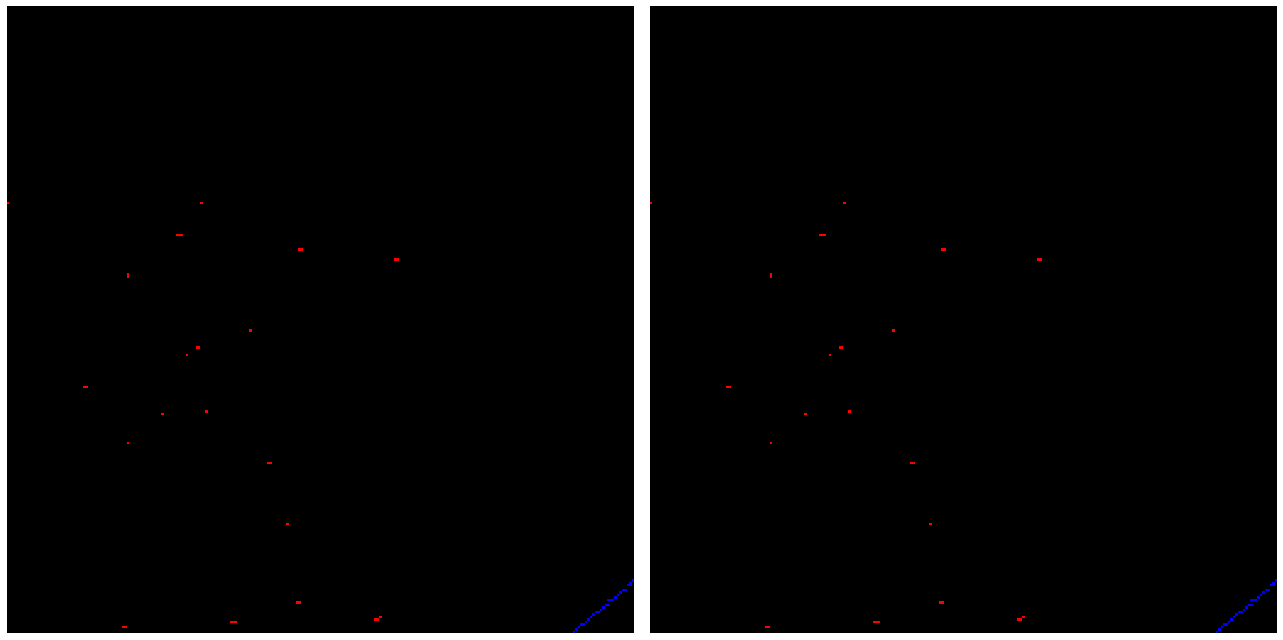

In [0]:
learner.is_training = False
learner.set_verbose(2)
for i, batch in enumerate(learner.bunch.valid_dl):
    if i == 0:
        learner._batch(10, i, batch)
        break
learner.set_verbose(0)

In [0]:
!ls -l validation_10_*.p*

-rw-r--r-- 1 root root  5920 Jan 22 11:38 validation_10_0_0.pdf
-rw-r--r-- 1 root root  5937 Jan 22 11:38 validation_10_0_0.png
-rw-r--r-- 1 root root  5148 Jan 22 11:40 validation_10_0_10.pdf
-rw-r--r-- 1 root root  5467 Jan 22 11:40 validation_10_0_10.png
-rw-r--r-- 1 root root  4445 Jan 22 11:40 validation_10_0_11.pdf
-rw-r--r-- 1 root root  4987 Jan 22 11:40 validation_10_0_11.png
-rw-r--r-- 1 root root  4909 Jan 22 11:40 validation_10_0_12.pdf
-rw-r--r-- 1 root root  5302 Jan 22 11:40 validation_10_0_12.png
-rw-r--r-- 1 root root  5055 Jan 22 11:40 validation_10_0_13.pdf
-rw-r--r-- 1 root root  5453 Jan 22 11:40 validation_10_0_13.png
-rw-r--r-- 1 root root  4311 Jan 22 11:40 validation_10_0_14.pdf
-rw-r--r-- 1 root root  4880 Jan 22 11:40 validation_10_0_14.png
-rw-r--r-- 1 root root  4718 Jan 22 11:40 validation_10_0_15.pdf
-rw-r--r-- 1 root root  5252 Jan 22 11:40 validation_10_0_15.png
-rw-r--r-- 1 root root  4341 Jan 22 11:40 validation_10_0_16.pdf
-rw-r--r-- 1 root root  489

In [0]:
!tar czf batch_images.tar.gz validation_10*.p*

In [0]:
files.download("batch_images.tar.gz")

# Analysis - Plot learning rates

In [0]:
!tar czf validation.tar.gz validation*.pdf validation*.png
files.download("validation.tar.gz")

In [0]:
lrs1 = learner.history["lr"]
losses1 = learner.history["train_loss"]
accuracies1 = learner.history["train_acc"]
val_lrs1 = (learner.history["lr"])[::4]
val_losses1 = learner.history["val_loss"]
val_accuracies1 = learner.history["val_acc"]

In [0]:
lrs = []
losses = []
accuracies = []
val_lrs = []
val_losses = []
val_accuracies = []

In [0]:
lrs.append(lrs1)
losses.append(losses1)
accuracies.append(accuracies1)
val_lrs.append(val_lrs1)
val_losses.append(val_losses1)
val_accuracies.append(val_accuracies1)

In [0]:
def plot_lr_loss_acc(lrs, losses, accuracies, name, labels=None):
    fig, axs = plt.subplots(3, 1, figsize=(10,15), sharex=True)
    yy = np.array([lrs, losses, accuracies])
    axes = ["lr", "loss", "acc"]
    for i, ax in enumerate(axs):
        ax.set_xlabel("batch", fontsize=20)
        ax.set_ylabel(axes[i], fontsize=20)
        if len(yy[i].shape) == 1:
            ax.plot(range(len(yy[i])), yy[i])
        else:
            for j, y in enumerate(yy[i]):
                ax.plot(range(len(y)), y, label=labels[j])
    for ax in axs:
        ax.label_outer()
        ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.legend(prop={'size': 20})
    save_figure(fig, name)

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


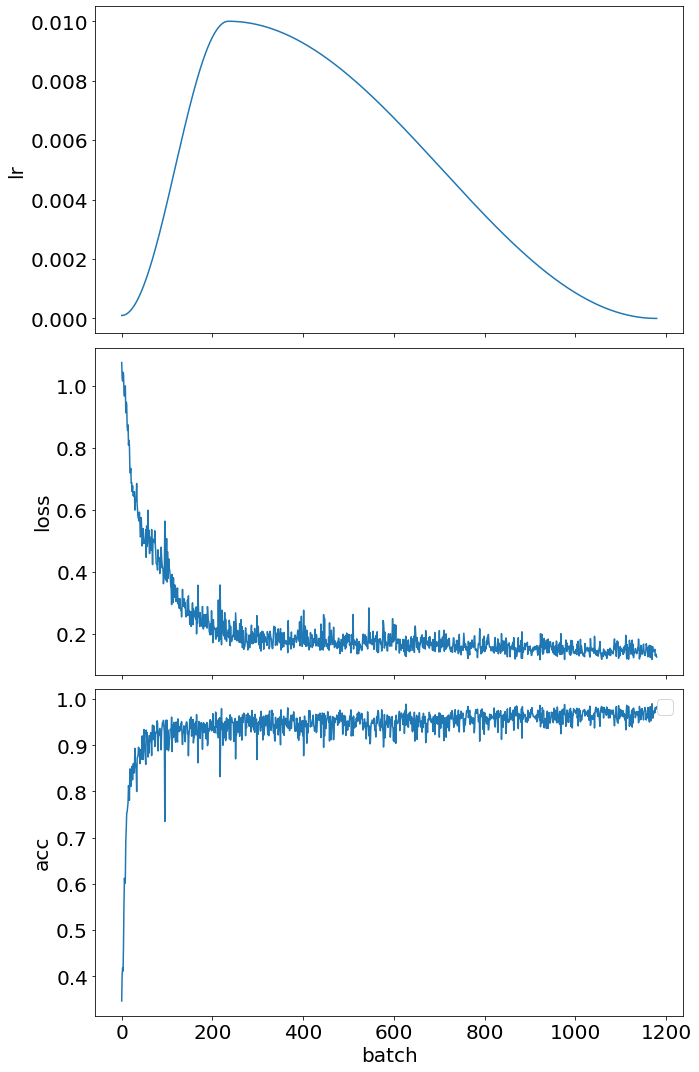

In [0]:
plot_lr_loss_acc(lrs, losses, accuracies, "LRLossAccByBatch", labels=[""])
#plot_lr_loss_acc(val_lrs, val_losses, val_accuracies, "ValLRLossAccByBatch", labels=["Max LR=5e-3", "Max LR=1e-2", "Max LR=1e-1", "Max LR=3e-2"])
#plot_lr_loss_acc(val_lrs, val_losses, val_accuracies, "ValLRLossAccByBatch", labels=["Linear One-cycle", "Constant", "Exp decay", "Linear decay", "Cosine One-cycle"])

# Analysis - Plot network performance by epoch

In [0]:
# This hack is only needed if activation plots have been run, because this needs adds a single batch to the history
learner.history["val_loss"] = learner.history["val_loss"][0:40]
learner.history["val_acc"] = learner.history["val_acc"][0:40]
learner.history["val_acc_track"] = learner.history["val_acc_track"][0:40]
learner.history["val_acc_shower"] = learner.history["val_acc_shower"][0:40]

In [0]:
def batch_to_epoch(values, batches_per_epoch):
    x = torch.Tensor(values)
    x = x.reshape(x.size(0) // batches_per_epoch, batches_per_epoch)
    return x.mean(axis = 1).cpu()

def plot_loss_acc(learner, n_train_batches, n_val_batches, name):
    fig, ax = plt.subplots(figsize=(15,10))
    training_losses = batch_to_epoch(learner.history["train_loss"], n_train_batches)
    training_accuracies = batch_to_epoch(learner.history["train_acc"], n_train_batches)
    val_losses = batch_to_epoch(learner.history["val_loss"], n_val_batches)
    val_accuracies = batch_to_epoch(learner.history["val_acc"], n_val_batches)
    xx = range(1, 1 + len(training_losses))
    ax.set_xlabel("epoch", fontsize=20)
    ax.plot(xx, training_losses, c='black', label="Training loss")
    ax.plot(xx, training_accuracies, c='red', label="Training accuracy")
    ax.plot(xx, val_losses, c='blue', label="Validation loss")
    ax.plot(xx, val_accuracies, c='cyan', label="Validation accuracy")
    plt.tick_params(labelsize=20)
    plt.tight_layout()
    plt.legend(prop={'size': 20})
    save_figure(fig, name)

def plot_loss_acc_by_type(learner, n_train_batches, n_val_batches, name):
    fig, ax = plt.subplots(figsize=(15,10))
    training_losses = batch_to_epoch(learner.history["train_loss"], n_train_batches)
    training_accuracies = batch_to_epoch(learner.history["train_acc"], n_train_batches)
    val_losses = batch_to_epoch(learner.history["val_loss"], n_val_batches)
    val_accuracies = batch_to_epoch(learner.history["val_acc"], n_val_batches)
    val_accuracies_track = batch_to_epoch(learner.history["val_acc_track"], n_val_batches)
    val_accuracies_shower = batch_to_epoch(learner.history["val_acc_shower"], n_val_batches)
    xx = range(1, 1 + len(training_losses))
    ax.set_xlabel("epoch", fontsize=20)
    ax.plot(xx, training_losses, label="Train loss")
    ax.plot(xx, training_accuracies, label="Train acc")
    ax.plot(xx, val_losses, label="Val loss")
    ax.plot(xx, val_accuracies, label="Val acc")
    ax.plot(xx, val_accuracies_track, label="Val track acc")
    ax.plot(xx, val_accuracies_shower, label="Val shower acc")
    plt.tick_params(labelsize=20)
    plt.tight_layout()
    plt.legend(prop={'size': 20})
    save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


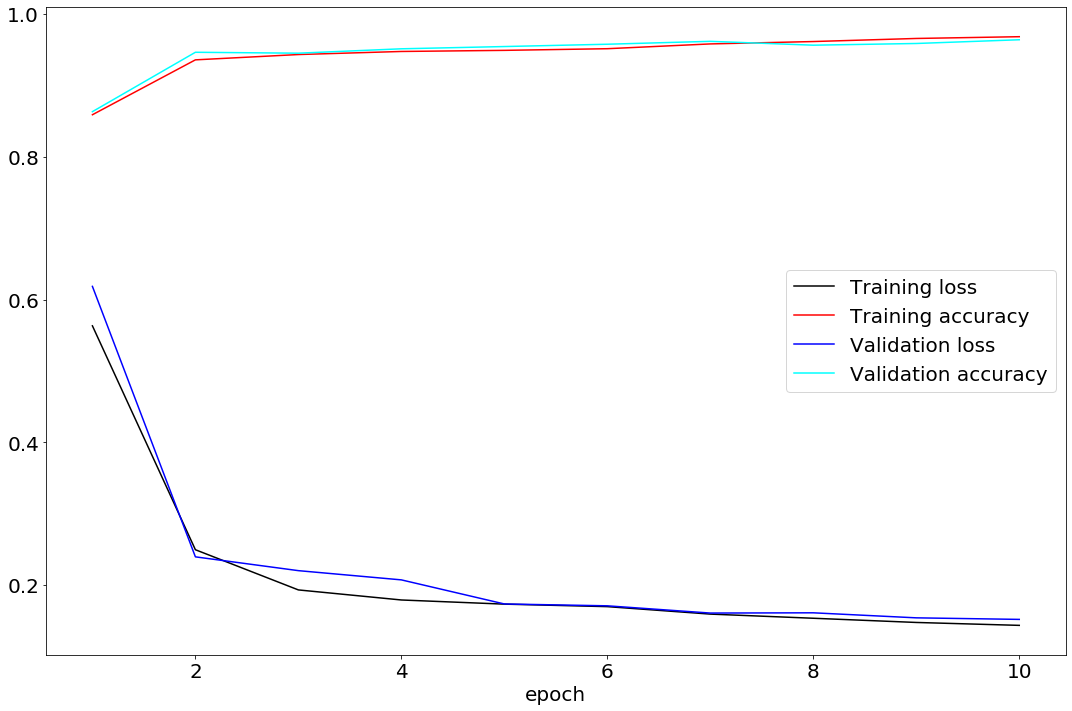

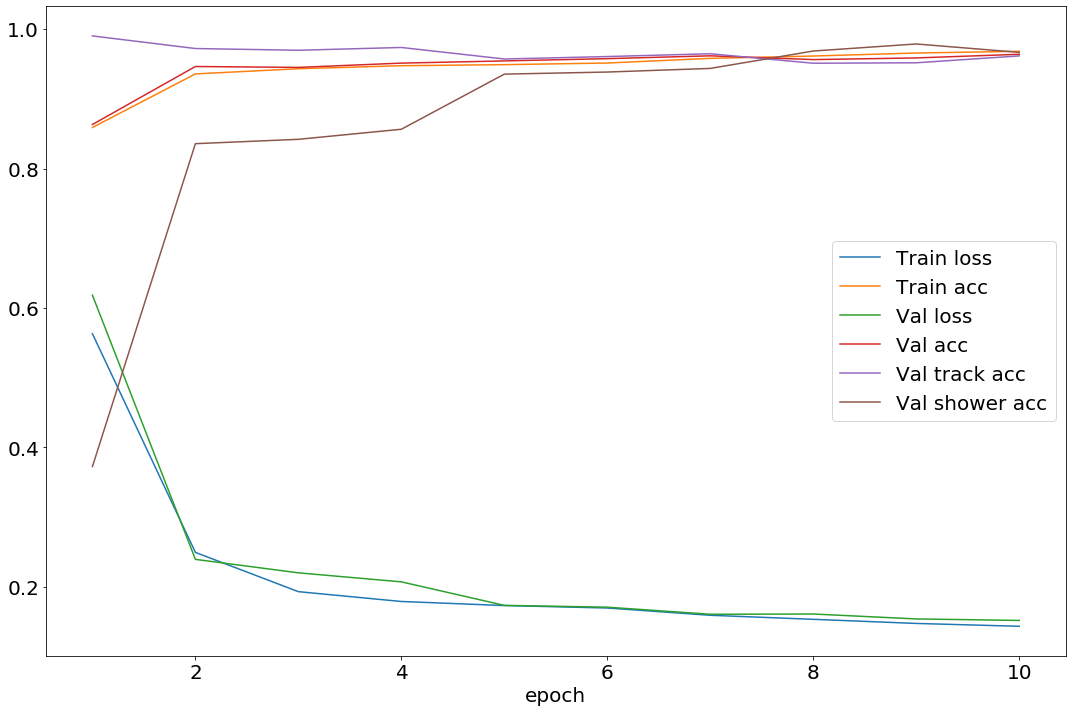

In [0]:
plot_loss_acc(learner, len(bunch.train_dl), len(bunch.valid_dl), "TrainingByEpoch")
plot_loss_acc_by_type(learner, len(bunch.train_dl), len(bunch.valid_dl), "DetailByEpoch")

In [0]:
!tar czf network_stats.tar.gz Training*.p* Detail*.p* # *.eps *.npy
files.download("network_stats.tar.gz")

# Analysis - Plot activations

In [0]:
learner.is_training = False
for i, batch in enumerate(learner.bunch.valid_dl):
    if i == 0:
        learner._batch(10, i, batch)
        break

In [0]:
def visualise_features(activations, name, indices):
    act = activations[name].squeeze()
    choices = list(range(act.size(1)))
    size = int(np.ceil(np.sqrt(act.size(1))))
    print(act.size(), size)
    act = act[:,choices]
    for img_idx in indices:
        fig, ax = plt.subplots(size, size, figsize=(3 * size, 3 * size))
        tot_act = torch.sum(act[img_idx], dim=0)
        for filter_idx in range(act.size(1)):
            # Standardize the filter color map range within a single event
            vmin, vmax = torch.min(act[img_idx]), torch.max(act[img_idx])
            ax[filter_idx // size, filter_idx % size].axis('off')
            ax[filter_idx // size, filter_idx % size].imshow(act[img_idx, filter_idx].cpu(), cmap=plt.get_cmap("Greys_r"), vmin=vmin, vmax=vmax)
        for filter_idx in range(act.size(1), size * size):
            ax[filter_idx // size, filter_idx % size].axis('off')
        plt.tight_layout(pad=0.2)
        save_figure(plt, f"{name}_{img_idx}")
        #plt.close()

In [0]:
bunch.valid_filenames[2]

'Image_DUNEFD_MC11_CaloHitListW_149_2_4.png'

In [0]:
# Visualize feature maps
names = ['DSConv1','DSConv2','DSConv3','DSConv4','Bridge',
         'USTConv1', 'USConv1','USTConv2','USConv2','USTConv3','USConv3','USTConv4','USConv4']
#names = ['ResBlock1']
indices = [8,11,14,17,22,41,42,43,53,59,77,94]
#indices = [33, 50, 68]
#indices = list(range(20))
indices = [2]
for name in names:
    visualise_features(activation, name, indices)

In [0]:
!tar czf activations_ds.tar.gz DS*.p*
!tar czf activations_bridge.tar.gz Bridge*.p*
!tar czf activations_us.tar.gz US*.p*

In [0]:
files.download("activations_ds.tar.gz")
files.download("activations_bridge.tar.gz")
files.download("activations_us.tar.gz")

# Analysis - Heat map

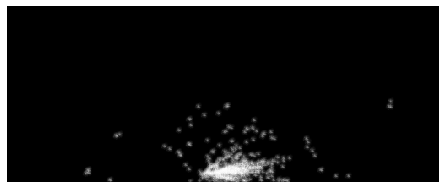

In [0]:
# Heat maps
names = ['ResBlock1','ResBlock2','ResBlock3','ResBlock4','Bridge',
         'TransConvBlock4','TransConvBlock3','TransConvBlock2','TransConvBlock1']
for name in names:
    act = activation[name].squeeze()
    for img_idx in [3, 19, 26, 27, 37]:
        tot_act = torch.sum(act[img_idx], dim=0)
        plt.axis('off')
        plt.imshow(tot_act, cmap=plt.get_cmap("Greys_r"))
        plt.tight_layout(pad=0)
        iu.save_figure(plt, f"{name}_{img_idx}_heatmap")

# Analysis - Weight plots

In [0]:
def visualise_weights(filters, name, vmin, vmax):
    N = filters.size(0)
    C = filters.size(1)
    choices = list(range(N))
    size = int(np.ceil(np.sqrt(N)))
    print(filters.size(), size)
    filters = filters[choices, :]
    for channel in range(C):
        fig, ax = plt.subplots(size, size, figsize=(size, size))
        for filter_idx in range(N):
            ax[filter_idx // size, filter_idx % size].axis('off')
            ax[filter_idx // size, filter_idx % size].imshow(filters[filter_idx, channel].cpu(), cmap=plt.get_cmap("Greys_r"), vmin=vmin, vmax=vmax)
        for filter_idx in range(N, size * size):
            ax[filter_idx // size, filter_idx % size].axis('off')
        plt.tight_layout(pad=0.2)
        save_figure(plt, f"{name}_{channel}")
        plt.close()

In [0]:
for i, conv_block in enumerate([model.c1.block, model.c2.block, model.c3.block, model.c4.block]):
    vmin, vmax = torch.min(conv_block[0].weight.data), torch.max(conv_block[0].weight.data)
    visualise_weights(conv_block[0].weight.data, f"ResBlock{i + 1}_Conv1", vmin, vmax)
    vmin, vmax = torch.min(conv_block[3].weight.data), torch.max(conv_block[3].weight.data)
    visualise_weights(conv_block[3].weight.data, f"ResBlock{i + 1}_Conv2", vmin, vmax)

torch.Size([16, 1, 3, 3]) 4
torch.Size([16, 16, 3, 3]) 4
torch.Size([32, 16, 3, 3]) 6
torch.Size([32, 32, 3, 3]) 6
torch.Size([64, 32, 3, 3]) 8
torch.Size([64, 64, 3, 3]) 8
torch.Size([128, 64, 3, 3]) 12
torch.Size([128, 128, 3, 3]) 12


In [0]:
!tar czf weights_resblock1.tar.gz ResBlock1_Conv*.p*
!tar czf weights_resblock2.tar.gz ResBlock2_Conv*.p*
!tar czf weights_resblock3.tar.gz ResBlock3_Conv*.p*
!tar czf weights_resblock4.tar.gz ResBlock4_Conv*.p*

In [0]:
for i in range(1, 5):
    files.download(f"weights_resblock{i}.tar.gz")

# Misc

In [0]:
imgs = None
for batch in bunch.valid_dl:
    imgs, _ = batch
    break
imgs.shape[0]

48

In [0]:
# Training stats
batch_lrs = np.concatenate([i.learning_rates for i in info])
batch_losses = np.concatenate([s.get_losses() for s in stats])
batch_overall_accuracies = np.concatenate([s.get_accuracies() for s in stats])
batch_track_accuracies = np.concatenate([s.get_accuracies(TRACK) for s in stats])
batch_shower_accuracies = np.concatenate([s.get_accuracies(SHOWER) for s in stats])
batch_accuracies = np.array([batch_overall_accuracies, batch_track_accuracies, batch_shower_accuracies])

np.save("learning_rates", batch_lrs)
np.save("losses", batch_losses)
np.save("accuracies", batch_overall_accuracies)
np.save("track_accuracies", batch_track_accuracies)
np.save("shower_accuracies", batch_shower_accuracies)

In [0]:
# Validation stats
batch_val_losses = np.concatenate([s.get_losses() for s in val_stats])
batch_val_overall_accuracies = np.concatenate([s.get_accuracies() for s in val_stats])
batch_val_track_accuracies = np.concatenate([s.get_accuracies(TRACK) for s in val_stats])
batch_val_shower_accuracies = np.concatenate([s.get_accuracies(SHOWER) for s in val_stats])
batch_val_accuracies = np.array([batch_val_overall_accuracies, batch_val_track_accuracies, batch_val_shower_accuracies])

np.save("val_losses", batch_val_losses)
np.save("val_accuracies", batch_val_overall_accuracies)
np.save("val_track_accuracies", batch_val_track_accuracies)
np.save("val_shower_accuracies", batch_val_shower_accuracies)

In [0]:
plot_lr_loss_acc(batch_lrs, batch_losses, batch_accuracies, "LRLossAccByBatch")
plot_loss_acc(batch_val_losses, batch_val_accuracies, "LossAccByBatch")

NameError: ignored

In [0]:
# Upload pickle files
from google.colab import files
files.upload()

Saving flat_acc.npy to flat_acc.npy
Saving flat_losses.npy to flat_losses.npy
Saving flat_lr.npy to flat_lr.npy


{'flat_acc.npy': b"\x93NUMPY\x01\x00v\x00{'descr': '<f8', 'fortran_order': False, 'shape': (85,), }                                                           \n\x00\x00\x00`;\x8f\xe0?\x00\x00\x00`\x84\x1b\xe4?\x00\x00\x00\x80_r\xe7?\x00\x00\x00`=\xa3\xe6?\x00\x00\x00\x80\xbcU\xe7?\x00\x00\x00\x00\x1c\x88\xe8?\x00\x00\x00 Q9\xe8?\x00\x00\x00`\x00\xa1\xe8?\x00\x00\x00\xc0\xa5a\xea?\x00\x00\x00@\x10\xd5\xe9?\x00\x00\x00 c#\xe9?\x00\x00\x00\xe0\xae\x8b\xea?\x00\x00\x00\x80$\x80\xe9?\x00\x00\x00 \x03\xa6\xe9?\x00\x00\x00\xa0\x7f\xf7\xe9?\x00\x00\x00 \xb0o\xe9?\x00\x00\x00\xa0\xbfv\xea?\x00\x00\x00\xe08\x05\xea?\x00\x00\x00`\x1e\x90\xea?\x00\x00\x00\xa0?.\xeb?\x00\x00\x00\x80m\xbc\xea?\x00\x00\x00 \xec\xec\xe9?\x00\x00\x00\xc0\xdd\x16\xea?\x00\x00\x00 \xa2F\xea?\x00\x00\x00\x80\xa5\x16\xeb?\x00\x00\x00 \x91\xb9\xeb?\x00\x00\x00`\xd5\x99\xeb?\x00\x00\x00\x00q\xc0\xeb?\x00\x00\x00\xe0\xb9n\xeb?\x00\x00\x00`\x01h\xe9?\x00\x00\x00 \x84\r\xec?\x00\x00\x00 Ue\xec?\x00\x00\x00\x00\x92\x1e\xea?\x00\

In [0]:
# Upload some comparison data
import numpy as np
learning_rates = np.load("flat_lr.npy")
train_loss_batches = np.load("flat_losses.npy")
train_acc_batches = np.load("flat_acc.npy")

In [0]:
# Upload pickle files
!rm -f cycle_*.npy 
from google.colab import files
files.upload()

Saving cycle_acc.npy to cycle_acc.npy
Saving cycle_losses.npy to cycle_losses.npy
Saving cycle_lr.npy to cycle_lr.npy


{'cycle_acc.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f8\', \'fortran_order\': False, \'shape\': (85,), }                                                           \n\x00\x00\x00\x80\x8f\x0b\xdf?\x00\x00\x00\xc0\xc8\x0c\xe6?\x00\x00\x00\xa0Z\x8b\xe7?\x00\x00\x00`R\x82\xe5?\x00\x00\x00`\xdc+\xe7?\x00\x00\x00\xc0\x99b\xe8?\x00\x00\x00\x00&\xe3\xe8?\x00\x00\x00@\xf6N\xe9?\x00\x00\x00\xc0\xefN\xea?\x00\x00\x00\xc0\xbd.\xeb?\x00\x00\x00 \x98C\xea?\x00\x00\x00@(\x01\xea?\x00\x00\x00\x00\x84\x96\xeb?\x00\x00\x00\xe02W\xeb?\x00\x00\x00 \xce\x13\xea?\x00\x00\x00\x00\x16\xbc\xeb?\x00\x00\x00\x00\x8f^\xe6?\x00\x00\x00 \xe1N\xeb?\x00\x00\x00@U\xe0\xe9?\x00\x00\x00 ~\xc4\xe9?\x00\x00\x00\x80\x97;\xea?\x00\x00\x00\x80\x18.\xea?\x00\x00\x00\x80W\\\xe8?\x00\x00\x00\x00&$\xeb?\x00\x00\x00`\xf29\xea?\x00\x00\x00\xa0O"\xea?\x00\x00\x00`\x9f\xc0\xea?\x00\x00\x00 \xceW\xeb?\x00\x00\x00\xa0D\xff\xe9?\x00\x00\x00 <\xfe\xe9?\x00\x00\x00@o\xa2\xeb?\x00\x00\x00\x80\xcb\x86\xeb?\x00\x00\x00@M\x10\xeb?\x00\x00

In [0]:
cycle_lr = np.load("cycle_lr.npy")
cycle_losses = np.load("cycle_losses.npy")
cycle_acc = np.load("cycle_acc.npy")

In [0]:
def plot_multi_lr_loss_acc(lrs, losses, accuracies, lrs2, losses2, acc2, name):
    fig, axs = plt.subplots(2, 1, sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy_flat = [lrs, losses, accuracies]
    yy_cycle = [lrs2, losses2, acc2]
    xlabels = ["lr", "loss", "acc"]
    labels = ["Constant", "One-Cycle"]
    colors = [['black', 'black', 'black'],['red', 'red', 'red']]
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(xlabels[i])
        ax.plot(xx, yy_flat[i], c=colors[0][i], label=labels[0])
        ax.plot(xx, yy_cycle[i], c=colors[1][i], label=labels[1])
    axs[0].legend()
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    iu.save_figure(fig, name)

In [0]:
plot_multi_lr_loss_acc(learning_rates, train_loss_batches, train_acc_batches, cycle_lr, cycle_losses, cycle_acc, "MultiLRLossAcc")

NameError: ignored

In [0]:
#del x, y
#del images, masks
#del model
torch.cuda.empty_cache()

In [0]:
def plot_stat_epoch(train_stats, val_stats, stat="Loss"):
    epochs = np.array(list(range(1, len(train_stats) + 1)), dtype=np.int16)
    fig, ax = plt.subplots()
    ax.set_title(f'Model {stat}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'{stat}')
    ax.plot(epochs, train_stats, label='Training', c='red')
    ax.plot(epochs, val_stats, label='Validation', c='blue')
    if stat == "Loss": ax.legend(loc='upper right')
    else: ax.legend(loc='upper left')
    iu.save_figure(plt, f"Average{stat}VsTrainingEpoch")

In [0]:
train_loss_epochs = [s.get_losses().mean() for s in stats]
val_loss_epochs = [s.get_losses().mean() for s in val_stats]
plot_stat_epoch(train_loss_epochs, val_loss_epochs)

train_acc_epochs = [s.get_accuracies().mean() for s in stats]
val_acc_epochs = [s.get_accuracies().mean() for s in val_stats]
plot_stat_epoch(train_acc_epochs, val_acc_epochs, stat="Accuracy")

NameError: ignored

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps *.npy
#!tar cvzf images.tar.gz *.pdf
files.download("images.tar.gz")

DetailByBatch.png
DetailByEpoch.png
LRLossAccByBatch.png
TrainingByBatch.png
TrainingByEpoch.png
DetailByBatch.pdf
DetailByEpoch.pdf
LRLossAccByBatch.pdf
TrainingByBatch.pdf
TrainingByEpoch.pdf
DetailByBatch.eps
DetailByEpoch.eps
LRLossAccByBatch.eps
TrainingByBatch.eps
TrainingByEpoch.eps
tar: *.npy: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [0]:
!tar cvzf models.tar.gz *.pkl
files.download("models.tar.gz")

unet_0.pkl
unet_1.pkl
unet_2.pkl
unet_3.pkl
unet_4.pkl


In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

Total size: 0


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.


In [0]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_single(img, name, **kwargs):
    plt.imshow(img, **kwargs)
    plt.axis('off')
    plt.tight_layout()
    iu.save_figure(plt, f"validation_{name}")

def render_batch(inputs, predictions, masks, void_code):
    print(inputs.shape)
    N = inputs.shape[0]
    cmap_rb = ListedColormap(['black', 'red', 'blue'])
    norm_rb = BoundaryNorm([0., 0.5, 1.5, 2.], cmap_rb.N)
    xtr_rb = dict(cmap=cmap_rb, norm=norm_rb, alpha=1.0)

    cmap_w = ListedColormap(['black', 'white'])
    norm_w = BoundaryNorm([0., 0.5, 1.], cmap_w.N)
    xtr_w = dict(cmap=cmap_w, norm=norm_w, alpha=1.0)

    raw = inputs[:,0]
    pred_masks = iu.imagify(inputs, predictions, masks, void_code, N, False)

    for i, img in enumerate(raw):
        plot_single(img, f"raw_{i}", **xtr_w)

    for i, (pred, mask) in enumerate(pred_masks):
        plot_single(pred, f"pred_{i}", **xtr_rb)
        plot_single(mask, f"mask_{i}", **xtr_rb)

torch.Size([48, 1, 208, 512]) torch.Size([48, 208, 512])
(48, 1, 208, 512)


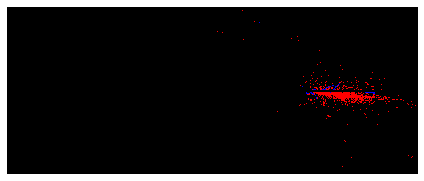

In [0]:
# Load and eval - simplify this, just get the last batch in the validation
# set, pass that through the network and display the output imagde and
# the prediction as separate images for ease of use in presentation
# Run
model.load_state_dict(torch.load("unet_0.pkl"))
model.eval()

for group in model.children():
    if type(group) == nn.Sequential:
        for child in group:
            if type(child)==nn.BatchNorm2d:
                child.track_running_stats = False

with torch.no_grad():
    dl = bunch.valid_dl
    for i, batch in enumerate(dl):
        if i < (len(dl) - 1): continue
        images, masks = batch
        print(images.size(), masks.size())
        x = Variable(images)
        y = Variable(masks)
        pred = model.forward(x)

        net_input = x.detach().numpy()
        net_pred = pred.detach().numpy()
        net_mask = y.detach().numpy()
        render_batch(net_input, net_pred, net_mask, void_code)

In [0]:
!tar cvzf images.tar.gz *.pdf
files.download("images.tar.gz")

validation_mask_0.pdf
validation_mask_10.pdf
validation_mask_11.pdf
validation_mask_12.pdf
validation_mask_13.pdf
validation_mask_14.pdf
validation_mask_15.pdf
validation_mask_16.pdf
validation_mask_17.pdf
validation_mask_18.pdf
validation_mask_19.pdf
validation_mask_1.pdf
validation_mask_20.pdf
validation_mask_21.pdf
validation_mask_22.pdf
validation_mask_23.pdf
validation_mask_24.pdf
validation_mask_25.pdf
validation_mask_26.pdf
validation_mask_27.pdf
validation_mask_28.pdf
validation_mask_29.pdf
validation_mask_2.pdf
validation_mask_30.pdf
validation_mask_31.pdf
validation_mask_32.pdf
validation_mask_33.pdf
validation_mask_34.pdf
validation_mask_35.pdf
validation_mask_36.pdf
validation_mask_37.pdf
validation_mask_38.pdf
validation_mask_39.pdf
validation_mask_3.pdf
validation_mask_40.pdf
validation_mask_41.pdf
validation_mask_42.pdf
validation_mask_43.pdf
validation_mask_44.pdf
validation_mask_45.pdf
validation_mask_46.pdf
validation_mask_47.pdf
validation_mask_4.pdf
validation_mask_